<a href="https://colab.research.google.com/github/sudarshan-koirala/youtube-stuffs/blob/main/llamaindex/llamaindex_Semi_Structured_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Joint Tabular/Semantic QA over Tesla 10K filing.

## [Youtube video covering this notebook](https://youtu.be/_4-L3l4TnbY?si=jgaWMc9EJ5Iyk-rx)

Tesla 10K filing refers to the annual report on Form 10-K that Tesla, Inc. files with the Securities and Exchange Commission (SEC) every year.

[LlamaIndex documentation](https://docs.llamaindex.ai/en/stable/examples/query_engine/sec_tables/tesla_10q_table.html#extract-elements)

[Tesla 10k report](https://www.sec.gov/Archives/edgar/data/1318605/000095017022000796/tsla-20211231.htm)

- Ask questions over Tesla 10K with understanding of both the unstructured text as well as embedded tables.

- [Unstructured](https://unstructured.io/) to parse out the tables, and use [LlamaIndex](https://www.llamaindex.ai/) recursive retrieval to index/retrieve tables if necessary given the user question.

In [1]:
%%capture
!pip install llama-index

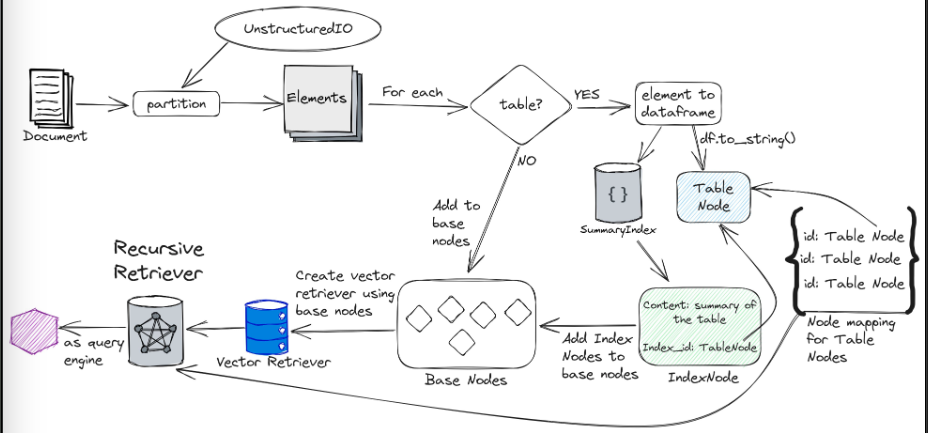

## Data Extraction

In [2]:
!wget "https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1" -O tesla_2021_10k.htm
!wget "https://www.dropbox.com/scl/fi/rkw0u959yb4w8vlzz76sa/tesla_2020_10k.htm?rlkey=tfkdshswpoupav5tqigwz1mp7&dl=1" -O tesla_2020_10k.htm

--2023-10-25 13:11:54--  https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9840931acf7f88d0c7f5b69c7c.dl.dropboxusercontent.com/cd/0/inline/CGQu79WzB1Dj7Z_IDptEu97xBX9jht3JG_sBqaIzNX-aQMu6x14CVt7iBB1S4gz-tGYkpJkjT0rszGqvL_qxkQC95lwImtcHuOmhWT5ZjB-y9dC58_e0VvwhY1H08RWZslM/file?dl=1# [following]
--2023-10-25 13:11:55--  https://uc9840931acf7f88d0c7f5b69c7c.dl.dropboxusercontent.com/cd/0/inline/CGQu79WzB1Dj7Z_IDptEu97xBX9jht3JG_sBqaIzNX-aQMu6x14CVt7iBB1S4gz-tGYkpJkjT0rszGqvL_qxkQC95lwImtcHuOmhWT5ZjB-y9dC58_e0VvwhY1H08RWZslM/file?dl=1
Resolving uc9840931acf7f88d0c7f5b69c7c.dl.dropboxusercontent.com (uc9840931acf7f88d0c7f5b69c7c.dl.dropboxusercontent.com)... 162.125.2.15, 2620:100:6017:15::a27d:20f


In [3]:
from llama_index.readers.file.flat_reader import FlatReader
from pathlib import Path

reader = FlatReader()
docs_2021 = reader.load_data(Path("tesla_2021_10k.htm"))
docs_2020 = reader.load_data(Path("tesla_2020_10k.htm"))

In [73]:
#docs_2021

## What does the parser does ?

- extracts tables from data
- converts those tables to Dataframe
- for each of those tables, it creates 2 nodes
- one Table Node that contains the Dataframe as string
- another IndexNode that stores the summary of that table and a reference to that Table Node

In [6]:
!pip install unstructured lxml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.1/275.1 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 35.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 86.6 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=231b9b8f6ff6601b7c8f4a0a7acac8b7e391dc5018038c87ed7ea71bcc7394a2
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [75]:
# create UnstructuredElementNodeParser from LLamaIndex
from llama_index.node_parser import (
    UnstructuredElementNodeParser,
)

node_parser = UnstructuredElementNodeParser()

In [71]:
#UnstructuredElementNodeParser??

Next we partition the nodes using this built-in function of the Unstructured parser.

Here BaseNodes contain the regular nodes and the IndexNodes (not the Table Nodes)

NodeMapping contains {id -> Node} mapping for those remaining Table Nodes.

In [10]:
import openai
import os

# find API key in console at https://platform.openai.com/account/api-keys

os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"
openai.api_key = os.environ["OPENAI_API_KEY"]

In [11]:
import os
import pickle

if not os.path.exists("2021_nodes.pkl"):
    raw_nodes_2021 = node_parser.get_nodes_from_documents(docs_2021)
    pickle.dump(raw_nodes_2021, open("2021_nodes.pkl", "wb"))
else:
    raw_nodes_2021 = pickle.load(open("2021_nodes.pkl", "rb"))

100%|██████████| 105/105 [17:06<00:00,  9.77s/it]


In [47]:
base_nodes_2021, node_mappings_2021 = node_parser.get_base_nodes_and_mappings(
    raw_nodes_2021
)

In [48]:
len(node_mappings_2021)

105

In [52]:
type(node_mappings_2021)

dict

In [70]:
from pprint import pprint
res = next(iter(node_mappings_2021.items()))
pprint("The first key-value pair of dictionary is : " + str(res))

("The first key-value pair of dictionary is : ('id_13_table', "
 "TextNode(id_='id_13_table', embedding=None, metadata={}, "
 'excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], '
 'relationships={}, '
 "hash='6bae6019df17199a70d08906203113fc6ab8e50a2d18ee43a37497591e343b9f', "
 "text='                                                                                                                             "
 '\\n0                           Delaware                                      '
 '91-2197729                                         \\n1    (State or other '
 'jurisdiction of  incorporation or organization)                  (I.R.S. '
 "Employer  Identification No.)  ', start_char_idx=None, end_char_idx=None, "
 "text_template='{metadata_str}\\n\\n{content}', metadata_template='{key}: "
 "{value}', metadata_seperator='\\n'))")


In [53]:
type(base_nodes_2021)

list

In [19]:
len(base_nodes_2021)

249

In [37]:
base_nodes_2021[0]

TextNode(id_='c60c4921-b545-43eb-998d-9d1621ec74b1', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='1a3eb4c4-66f7-4432-864a-1050eafffc2f', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='9790edb48aba209a4556b1995a3b1500fc98c6705021def85628fbbb935630f5')}, hash='9790edb48aba209a4556b1995a3b1500fc98c6705021def85628fbbb935630f5', text='UNITED STATES\n\nSECURITIES AND EXCHANGE COMMISSION\n\nWashington, D.C. 20549\n\nFORM 10-K\n\n(Mark One)\n\nFor the fiscal year ended December 31, 2021\n\nOR\n\nFor the transition period from _________ to _________\n\nCommission File Number: 001-34756\n\nTesla, Inc.\n\n(Exact name of registrant as specified in its charter)', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n')

In [44]:
base_nodes_2021[245]

IndexNode(id_='id_1836_table_ref', embedding=None, metadata={'col_schema': 'Column: Date\nType: string\nSummary: The date mentioned in the context\n\nColumn: /s/ Elon Musk\nType: string\nSummary: Signature of Elon Musk\n\nColumn: Elon Musk\nType: string\nSummary: Name of the Chief Executive Officer\n\nColumn: Chief Executive Officer\nType: string\nSummary: Title of the Chief Executive Officer\n\nColumn: (Principal Executive Officer)\nType: string\nSummary: Additional information about the Chief Executive Officer'}, excluded_embed_metadata_keys=['col_schema'], excluded_llm_metadata_keys=[], relationships={}, hash='9bab05c2c15c667c0fa9a89602c656a08282f532700cfedf20f07833998d14a6', text='Table containing information about Tesla, Inc. and its Chief Executive Officer, Elon Musk', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', index_id='id_1836_table')

## Setup Recursive Retriever

Next, we create the `vector_index` using these `BaseNodes` (that doesn't have the Table nodes) and then create a `vector_retriever` with this index.

In [22]:
from llama_index.retrievers import RecursiveRetriever
from llama_index.query_engine import RetrieverQueryEngine
from llama_index import VectorStoreIndex

In [32]:
# construct top-level vector index + query engine
vector_index = VectorStoreIndex(base_nodes_2021)
vector_retriever = vector_index.as_retriever(similarity_top_k=1)

# query engine without RecursiveRetriever
vector_query_engine = vector_index.as_query_engine(similarity_top_k=1)

Now, we create the `RecursiveRetriever`
- 1st argument is the id of the recursion root, this is the retriever from where recursive retriever starts retrieving.
- 2nd argument is a dictionary containing all the retrievers, here we have only one, the root one, which we created using the base nodes earlier.



- For this use case, we only supply the NodeMapping of the Table nodes as node_dict argument to the RecursiveRetriever.These node(s) will be retrieved if the IndexNodes referring to one of these Table nodes is retrieved by our root retriever.

In [33]:
recursive_retriever = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever},
    node_dict=node_mappings_2021,
    verbose=True,
)
query_engine = RetrieverQueryEngine.from_args(recursive_retriever)

## Now we can ask some queries

In [25]:
response = query_engine.query("What was the revenue in 2020?")
print(str(response))

Retrieving with query id None: What was the revenue in 2020?
Retrieved node with id, entering: id_478_table
Retrieving with query id id_478_table: What was the revenue in 2020?
The revenue in 2020 was $31,536 million.


In [35]:
# compare against the baseline retriever
response = vector_query_engine.query("What was the revenue in 2020?")
print(str(response))

The revenue in 2020 was recorded in the column labeled "2020" and is of type number.


In [26]:
response = query_engine.query("What were the total cash flows in 2021?")
response

Retrieving with query id None: What were the total cash flows in 2021?
Retrieved node with id, entering: id_558_table
Retrieving with query id id_558_table: What were the total cash flows in 2021?


Response(response='The total cash flows in 2021 were $11,497 million.', source_nodes=[NodeWithScore(node=TextNode(id_='id_558_table', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, hash='1d493ffefb5dcb6d2b2057fc5124fb7aed0f76963d0a6e145c851e70da271f0b', text='                                                                                                                                                               \n0                                                               Year Ended December 31,                                                                        \n1                                  (Dollars in millions)                           2021                   2020                   2019                          \n2              Net cash provided by operating activities                              $    11,497                 $     5,943                $     2,405       \n3                  Net cash used

In [28]:
response.response

'The total cash flows in 2021 were $11,497 million.'

In [27]:
response.metadata

{'id_558_table': {}}

In [36]:
# compare against the baseline retriever

response = vector_query_engine.query("What were the total cash flows in 2021?")
print(str(response))

The total cash flows in 2021 cannot be determined based on the given context information.


In [29]:
response = query_engine.query("What are the risk factors for Tesla?")

Retrieving with query id None: What are the risk factors for Tesla?
Retrieving text node: Employees may leave Tesla or choose other employers over Tesla due to various factors, such as a very competitive labor market for talented individuals with automotive or technology experience, or any negative publicity related to us. In regions where we

19

have or will have operations, particularly significant engineering and manufacturing centers, there is strong competition for individuals with skillsets needed for our business, including specialized knowledge of electric vehicles, engineering and electrical and building construction expertise. Moreover, we may be impacted by perceptions relating to reductions in force that we have conducted in the past in order to optimize our organizational structure and reduce costs and the departure of certain senior personnel for various reasons. Likewise, as a result of our temporary suspension of various U.S. manufacturing operations in the first half 

In [30]:
response.response

'The risk factors for Tesla include a highly competitive labor market for skilled individuals in the automotive and technology industries, negative publicity, competition for talent in regions where they have operations, perceptions related to past reductions in force and the departure of senior personnel, competition from companies with greater financial resources, dependence on the services of Elon Musk, potential cyber-attacks or security incidents that could result in data breaches or intellectual property theft, and reliance on service providers who may also be vulnerable to security incidents.'

In [31]:
response.metadata

{'96b52efc-4a2b-4772-a72a-352c81896927': {}}

In [38]:
response = vector_query_engine.query("What are the risk factors for Tesla?")

In [39]:
response.response

"The risk factors for Tesla include strong competition for skilled individuals in the labor market, negative publicity, perceptions related to reductions in force and the departure of senior personnel, competition from companies with greater financial resources, dependence on the services of Elon Musk, potential cyber-attacks or security incidents, and reliance on service providers who may be vulnerable to security breaches. These factors could impact Tesla's ability to attract and retain qualified personnel, disrupt its business operations, harm its reputation, result in legal and financial exposure, and cause other adverse consequences."

In [40]:
response.metadata

{'96b52efc-4a2b-4772-a72a-352c81896927': {}}